<a href="https://colab.research.google.com/github/woncoh1/era1a7/blob/main/nbs/S7_06_lr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Summary
Summary of targets, results, and analysis

## Targets
- Hit 99.4 % test accuracy multiple times

## Results
- Best accuracy
    - Train = 99.19 %
    - [x] Test = 99.48 % (> 99.4 % in the last 2 epochs)
- [x] Number of Parameters = 4,392
- [x] Number of Epochs = 15

## Analysis
- We played with our model and dataset, so the time is ripe for enhancing the training process itself.
- Given that the number of epochs is fixed by customer requirement, and SGD is known to be the best optimizer, we focus on the learning rate.
- Instead of naive step down, or even step down on plateau, we use the [one cycle policy](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.OneCycleLR.html).
- Now we hit over 99.45 % twice, just with 4,392 parameters in 15 epochs!

>[Summary](#scrollTo=kjFgf9woqfAE)

>>[Targets](#scrollTo=kjFgf9woqfAE)

>>[Results](#scrollTo=kjFgf9woqfAE)

>>[Analysis](#scrollTo=kjFgf9woqfAE)

>[Device](#scrollTo=7QlJ9s_43tj4)

>>[Colab](#scrollTo=_qZEo7Ty13uh)

>>[Pytorch](#scrollTo=30q5EOnt11t3)

>[Data](#scrollTo=IZlN9TTM3yVC)

>>[Transform](#scrollTo=lDnD-zELz8as)

>>[Dataset](#scrollTo=N4NSVJ0DwivZ)

>>[DataLoader](#scrollTo=vb2R5ZBFzi08)

>>[Inspect](#scrollTo=WD-_p0o7PQN_)

>[Model](#scrollTo=5v1EC4vo3upW)

>[Trainer](#scrollTo=_KvOD_jk3zrp)

>>[LR scheduler](#scrollTo=esGeElaYtm2s)

>>[LR finder](#scrollTo=pLdoCYstSAxO)

>>[Training log](#scrollTo=XX17eceqtai9)

>[Evaluate](#scrollTo=BoqfYvTXUPFb)



In [1]:
!git clone https://github.com/woncoh1/era1a7.git

Cloning into 'era1a7'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 67 (delta 36), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (67/67), 22.73 KiB | 1.34 MiB/s, done.


In [2]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torchsummary import summary

from era1a7 import data, models, engine, utils

In [3]:
torch.manual_seed(1)

# Device

## Colab
Runtime
- Hardware accelerator: GPU
- GPU type: T4
- Runtime shape: Standard

## Pytorch
- cpu
- cuda
- mps

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Data
- Transforms
- Batch size

## Transform
- https://pytorch.org/vision/master/transforms.html
- https://pytorch.org/vision/stable/auto_examples/plot_transforms.html

In [5]:
transform = {
    'train': transforms.Compose([
        transforms.RandomApply([transforms.CenterCrop(22)], p=0.1), # Crop
        transforms.Resize((28, 28)), # Resize after crop
        transforms.RandomRotation((-15., 15.)), # Rotation
        transforms.ToTensor(), # Standardization
        transforms.Normalize((0.1307,), (0.3081,)), # Normalization
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
    ]),
}

## Dataset

In [6]:
dataset = data.get_dataset(transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 148043724.21it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 124882158.58it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 65088292.17it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 21821911.53it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



## DataLoader

In [7]:
params_dataloader = {
    'batch_size': 128,
    'shuffle': True,
    'num_workers': 0,
    'pin_memory': True,
}

In [8]:
loader = data.get_dataloader(dataset, params_dataloader)

## Inspect

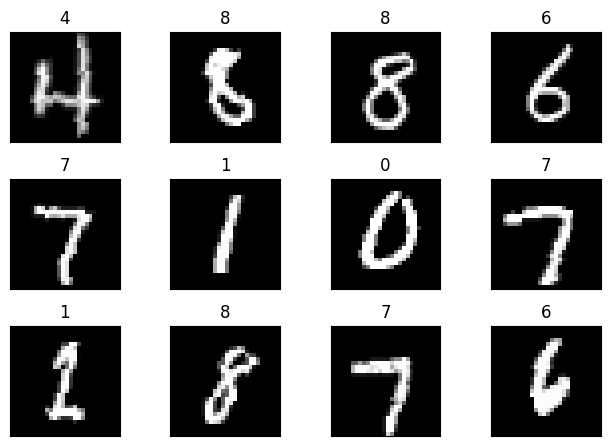

In [9]:
utils.inspect_batch(loader['train'])

# Model

In [10]:
criterion = F.nll_loss
model = models.Model3().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
         Dropout2d-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]             144
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
         Dropout2d-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 16, 24, 24]             256
             ReLU-10           [-1, 16, 24, 24]               0
      BatchNorm2d-11           [-1, 16, 24, 24]              32
        Dropout2d-12           [-1, 16, 24, 24]               0
           Conv2d-13           [-1, 16, 22, 22]             144
             ReLU-14           [-1, 16,

# Trainer

## LR scheduler
Why is the max learning rate so high (1.0)?
- Small model size: As we saw in the backpropagation Excel spreadsheet, models with very few number of parameters need high learning rates for the loss to decrease exponentially
- Learning-rate finder: As we can see below,

In [11]:
params_trainer = {
    'num_epochs': 15,
}
params_optimizer = {
    'lr': 1.0,
    'momentum': 0.9,
}
params_scheduler = {
    'max_lr': params_optimizer['lr'],
    'epochs': params_trainer['num_epochs'],
    'steps_per_epoch': len(loader['train']), # 1 batch per step
}

optimizer = optim.SGD(model.parameters(), **params_optimizer)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, **params_scheduler)

## LR finder
- https://sgugger.github.io/the-1cycle-policy.html
- https://iconof.com/1cycle-learning-rate-policy
- https://www.kaggle.com/code/residentmario/one-cycle-learning-rate-schedulers

In [12]:
trn = data.get_dataloader(dataset, params_dataloader)['train']
net = models.Model3().to(device)
opt = optim.SGD(net.parameters(), **params_optimizer)
lrs, losses = engine.find_lr(device, trn, net, criterion, opt)

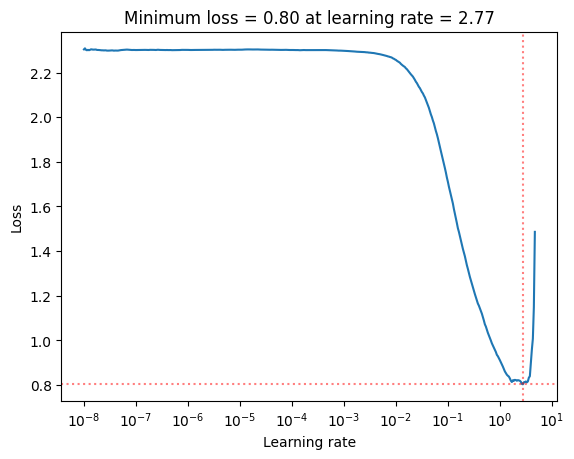

In [13]:
utils.plot_lr(lrs, losses)

## Training log

In [14]:
results = engine.train(
    device,
    loader['train'],
    loader['test'],
    model,
    criterion,
    optimizer,
    scheduler,
    params_trainer['num_epochs'],
    onecyclelr=True,
)

  0%|          | 0/469 [00:00<?, ?it/s]

Train: Loss = 0.00268, Accuracy = 88.88%, Epoch = 1
Test : Loss = 0.00089, Accuracy = 96.31%



  0%|          | 0/469 [00:00<?, ?it/s]

Train: Loss = 0.00091, Accuracy = 96.37%, Epoch = 2
Test : Loss = 0.00107, Accuracy = 95.62%



  0%|          | 0/469 [00:00<?, ?it/s]

Train: Loss = 0.00076, Accuracy = 96.95%, Epoch = 3
Test : Loss = 0.00045, Accuracy = 98.20%



  0%|          | 0/469 [00:00<?, ?it/s]

Train: Loss = 0.00065, Accuracy = 97.37%, Epoch = 4
Test : Loss = 0.00045, Accuracy = 98.06%



  0%|          | 0/469 [00:00<?, ?it/s]

Train: Loss = 0.00055, Accuracy = 97.89%, Epoch = 5
Test : Loss = 0.00030, Accuracy = 98.89%



  0%|          | 0/469 [00:00<?, ?it/s]

Train: Loss = 0.00052, Accuracy = 97.94%, Epoch = 6
Test : Loss = 0.00025, Accuracy = 98.89%



  0%|          | 0/469 [00:00<?, ?it/s]

Train: Loss = 0.00046, Accuracy = 98.19%, Epoch = 7
Test : Loss = 0.00043, Accuracy = 98.31%



  0%|          | 0/469 [00:00<?, ?it/s]

Train: Loss = 0.00045, Accuracy = 98.22%, Epoch = 8
Test : Loss = 0.00047, Accuracy = 98.25%



  0%|          | 0/469 [00:00<?, ?it/s]

Train: Loss = 0.00038, Accuracy = 98.50%, Epoch = 9
Test : Loss = 0.00036, Accuracy = 98.60%



  0%|          | 0/469 [00:00<?, ?it/s]

Train: Loss = 0.00034, Accuracy = 98.66%, Epoch = 10
Test : Loss = 0.00020, Accuracy = 99.21%



  0%|          | 0/469 [00:00<?, ?it/s]

Train: Loss = 0.00036, Accuracy = 98.58%, Epoch = 11
Test : Loss = 0.00021, Accuracy = 99.13%



  0%|          | 0/469 [00:00<?, ?it/s]

Train: Loss = 0.00028, Accuracy = 98.83%, Epoch = 12
Test : Loss = 0.00016, Accuracy = 99.36%



  0%|          | 0/469 [00:00<?, ?it/s]

Train: Loss = 0.00025, Accuracy = 99.02%, Epoch = 13
Test : Loss = 0.00014, Accuracy = 99.38%



  0%|          | 0/469 [00:00<?, ?it/s]

Train: Loss = 0.00021, Accuracy = 99.13%, Epoch = 14
Test : Loss = 0.00014, Accuracy = 99.48%



  0%|          | 0/469 [00:00<?, ?it/s]

Train: Loss = 0.00020, Accuracy = 99.19%, Epoch = 15
Test : Loss = 0.00014, Accuracy = 99.46%



# Evaluate

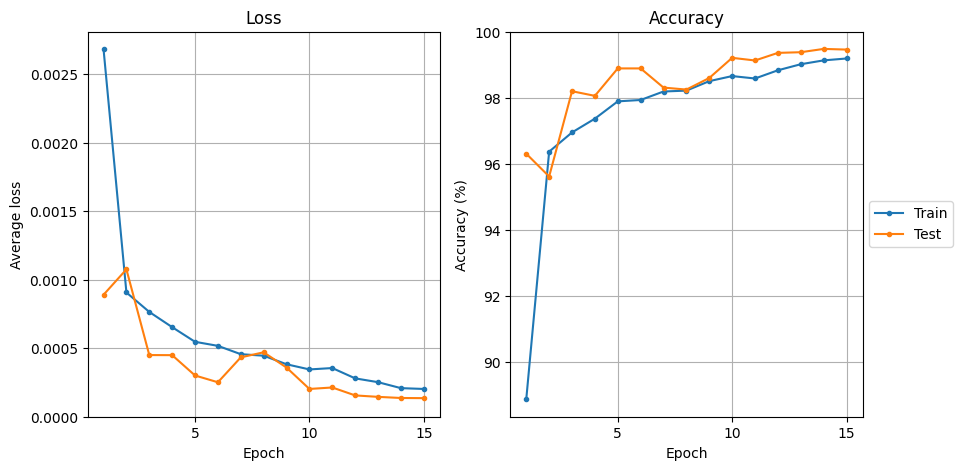

In [15]:
utils.plot_curves(results)